In [133]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('./RegularSeasonCompactResults.csv')
detailed_data = pd.read_csv('./RegularSeasonDetailedResults.csv')
seed = pd.read_csv('./NCAATourneySeeds.csv')
team_names = pd.read_csv('./Teams.csv')

In [127]:
tourney_compact = pd.read_csv('./NCAATourneyCompactResults.csv')

In [4]:
data.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [5]:
detailed_data['Season'].value_counts()

2017    5395
2016    5369
2014    5362
2015    5354
2013    5320
2010    5263
2012    5253
2009    5249
2011    5246
2008    5163
2007    5043
2006    4757
2005    4675
2003    4616
2004    4571
Name: Season, dtype: int64

In [6]:
team_name_dict = team_names.loc[:,['TeamID', 'TeamName']].set_index('TeamID').to_dict()['TeamName']

In [7]:
data['WTeamName'] = data['WTeamID'].map(team_name_dict)
data['LTeamName'] = data['LTeamID'].map(team_name_dict)

In [10]:
data.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WTeamName,LTeamName
0,1985,20,1228,81,1328,64,N,0,Illinois,Oklahoma
1,1985,25,1106,77,1354,70,H,0,Alabama St,S Carolina St
2,1985,25,1112,63,1223,56,H,0,Arizona,Houston Bap
3,1985,25,1165,70,1432,54,H,0,Cornell,Utica
4,1985,25,1192,86,1447,74,H,0,F Dickinson,Wagner


In [11]:
#These are the teams who historically have the most wins since 1985

data.groupby('WTeamName')['WTeamName'].count().sort_values(ascending = False)[:20]

WTeamName
Duke              846
Kansas            832
Kentucky          794
North Carolina    787
Arizona           776
Syracuse          756
Memphis           711
Louisville        706
Xavier            702
UNLV              696
Gonzaga           695
Connecticut       694
Michigan St       686
UCLA              684
Oklahoma          684
Cincinnati        681
Illinois          677
Temple            672
Florida           668
Texas             663
Name: WTeamName, dtype: int64

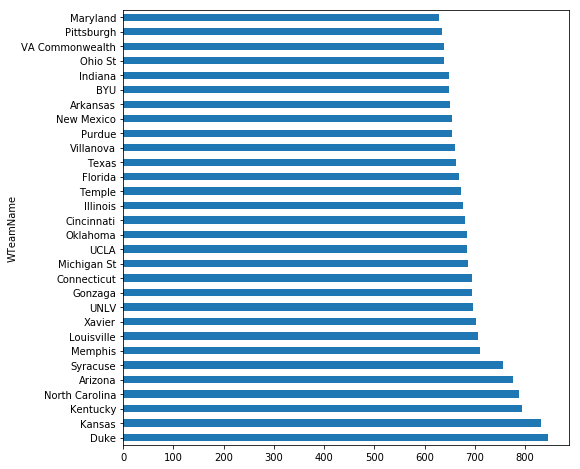

In [12]:
data.groupby('WTeamName')['WTeamName'].count().sort_values(ascending = False)[:30].plot(kind = 'barh', figsize = (8,8))

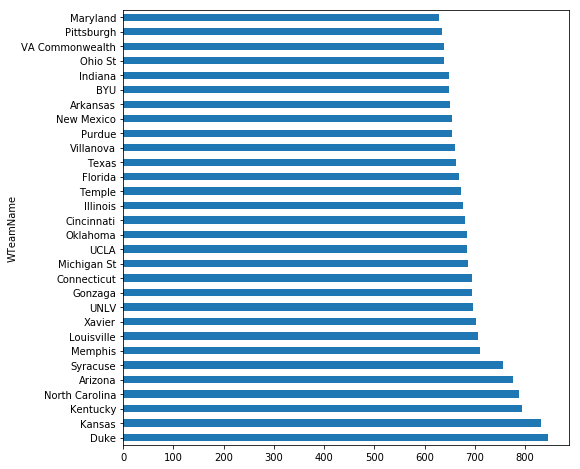

In [13]:
data.groupby('WTeamName')['WTeamName'].count().sort_values(ascending = False)[:30].plot(kind = 'barh', figsize = (8,8))

In [14]:
# Does the DayNum matter for a team winning or losing?  Let's take a look at the top 5 teams.

In [15]:
top_five = data.groupby('WTeamName')['WTeamName'].count().sort_values(ascending = False).keys()[0:5].tolist()

In [16]:
top_five

['Duke', 'Kansas', 'Kentucky', 'North Carolina', 'Arizona']

In [17]:
lower_five = data.groupby('WTeamName')['WTeamName'].count().sort_values(ascending = False).keys()[50:55].tolist()

In [18]:
lower_five

['WKU', 'UTEP', 'Old Dominion', 'Richmond', 'Missouri St']

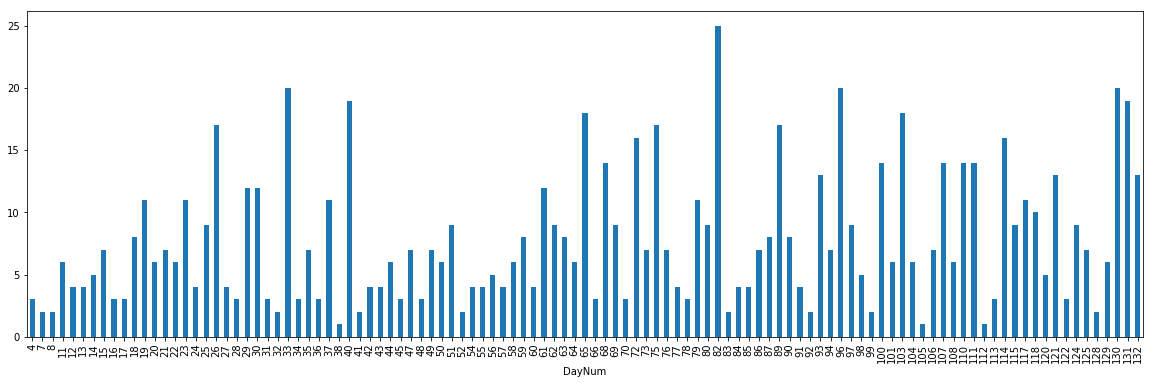

In [19]:
data.query("WTeamName == 'Duke'").groupby('DayNum').count()['WTeamName'].plot(kind = 'bar', figsize = (20,6))

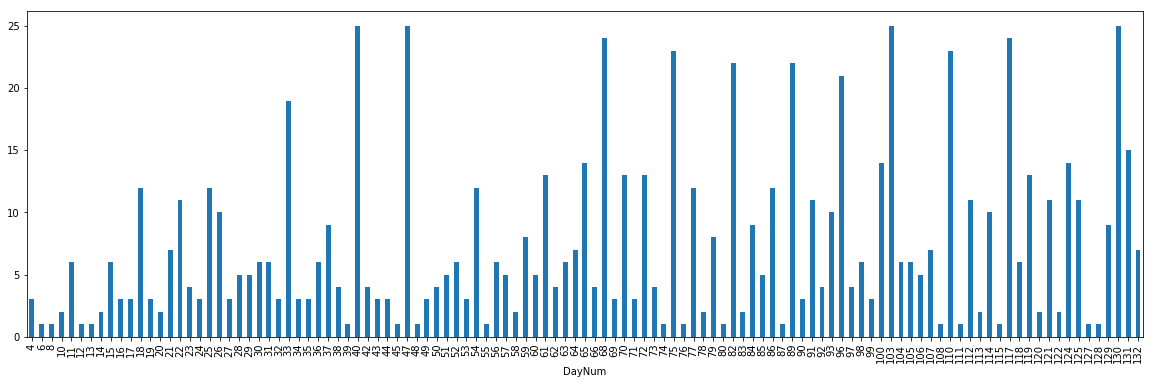

In [20]:
data.query("WTeamName == 'Kansas'").groupby('DayNum').count()['WTeamName'].plot(kind = 'bar', figsize = (20,6))

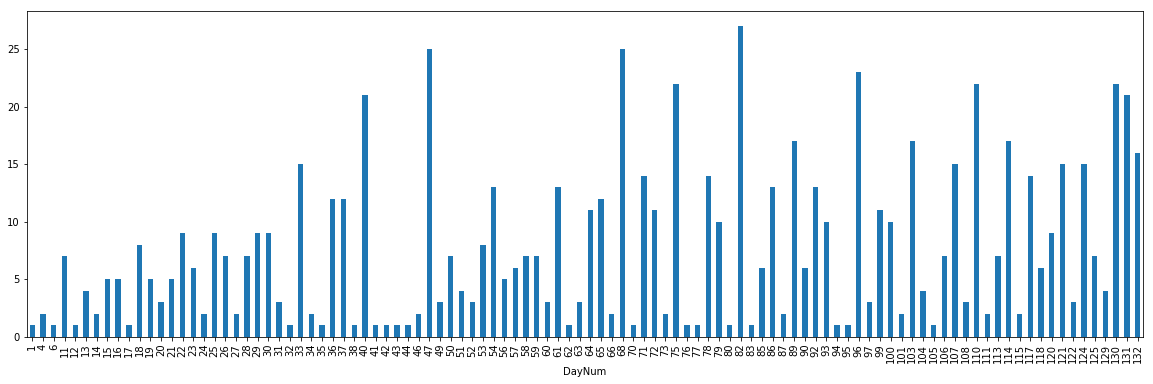

In [21]:
data.query("WTeamName == 'Kentucky'").groupby('DayNum').count()['WTeamName'].plot(kind = 'bar', figsize = (20,6))

In [22]:
lower_five

['WKU', 'UTEP', 'Old Dominion', 'Richmond', 'Missouri St']

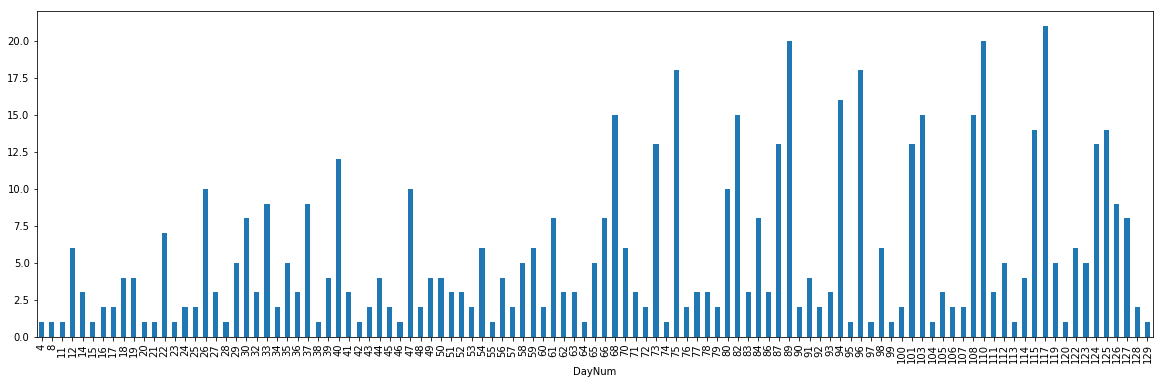

In [23]:
data.query("WTeamName == 'WKU'").groupby('DayNum').count()['WTeamName'].plot(kind = 'bar', figsize = (20,6))

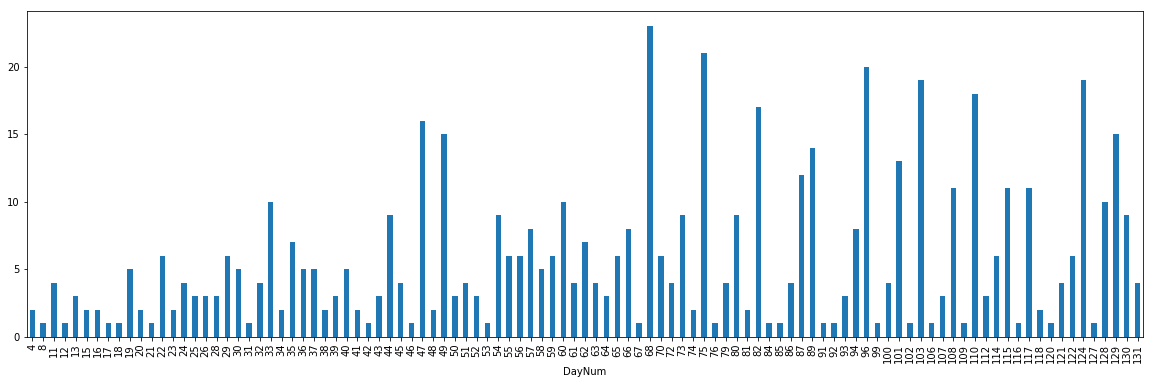

In [24]:
data.query("WTeamName == 'UTEP'").groupby('DayNum').count()['WTeamName'].plot(kind = 'bar', figsize = (20,6))

In [25]:
# # Things to look at:
# - Minutes?
# - Travel distance for the games?
# - "Seed" is going to be a really strong variable.

# # My ideas:
# Look at the winning teams and what their scoring is like.  Can I figure out if teams are more likely to win if they do more 3pt shots or dunks? or something?

In [26]:
seed['WTeamName'] = seed['TeamID'].map(team_name_dict)

In [27]:
seed.head()

,Season,Seed,TeamID,WTeamName
0,1985,W01,1207,Georgetown
1,1985,W02,1210,Georgia Tech
2,1985,W03,1228,Illinois
3,1985,W04,1260,Loyola-Chicago
4,1985,W05,1374,SMU


In [29]:
seed.query(" Seed == 'W01' ")[['Season','Seed', 'WTeamName']].head()

,Season,Seed,WTeamName
0,1985,W01,Georgetown
64,1986,W01,Duke
128,1987,W01,North Carolina
192,1988,W01,Temple
256,1989,W01,Georgetown


In [ ]:
seed.loc[seed['Seed'].str.contains("X"),['Season','Seed', 'WTeamName']].head()

In [30]:
top_seed = pd.DataFrame({
    "W01": seed.query(" Seed == 'W01' ")[['Season','Seed', 'WTeamName']]['WTeamName'].value_counts().keys()[:10],
    "W01_counts": seed.query(" Seed == 'W01' ")[['Season','Seed', 'WTeamName']]['WTeamName'].value_counts().tolist()[:10],
    
    "X01": seed.query(" Seed == 'X01' ")[['Season','Seed', 'WTeamName']]['WTeamName'].value_counts().keys()[:10],
    "X01_counts": seed.query(" Seed == 'X01' ")[['Season','Seed', 'WTeamName']]['WTeamName'].value_counts().tolist()[:10],
    
    "Y01": seed.query(" Seed == 'Y01' ")[['Season','Seed', 'WTeamName']]['WTeamName'].value_counts().keys()[:10],
    "Y01_counts": seed.query(" Seed == 'Y01' ")[['Season','Seed', 'WTeamName']]['WTeamName'].value_counts().tolist()[:10],
    
    "Z01": seed.query(" Seed == 'Z01' ")[['Season','Seed', 'WTeamName']]['WTeamName'].value_counts().keys()[:10],
    "Z01_counts": seed.query(" Seed == 'Z01' ")[['Season','Seed', 'WTeamName']]['WTeamName'].value_counts().tolist()[:10]
    
})

In [31]:
top_seed

,W01,W01_counts,X01,X01_counts,Y01,Y01_counts,Z01,Z01_counts
0,North Carolina,9,Kansas,5,Kansas,6,Arizona,4
1,Duke,7,Stanford,3,Kentucky,5,Kentucky,3
2,Georgetown,2,Duke,3,Michigan St,2,Connecticut,3
3,Villanova,2,Purdue,2,Oklahoma,2,UNLV,3
4,Temple,1,North Carolina,2,Louisville,2,Michigan St,2
5,Wake Forest,1,Arizona,2,Duke,2,North Carolina,2
6,Massachusetts,1,UCLA,2,Illinois,2,Kansas,2
7,Oklahoma,1,Ohio St,1,Minnesota,1,Michigan,2
8,Pittsburgh,1,Illinois,1,Villanova,1,Ohio St,1
9,Maryland,1,Texas,1,Auburn,1,Oklahoma,1


In [32]:
top_seed = pd.DataFrame({
    "W02": seed.query(" Seed == 'W02' ")[['Season','Seed', 'WTeamName']]['WTeamName'].value_counts().keys()[:10],
    "W02_counts": seed.query(" Seed == 'W02' ")[['Season','Seed', 'WTeamName']]['WTeamName'].value_counts().tolist()[:10],
    
    "X02": seed.query(" Seed == 'X02' ")[['Season','Seed', 'WTeamName']]['WTeamName'].value_counts().keys()[:10],
    "X02_counts": seed.query(" Seed == 'X02' ")[['Season','Seed', 'WTeamName']]['WTeamName'].value_counts().tolist()[:10],
    
    "Y02": seed.query(" Seed == 'Y02' ")[['Season','Seed', 'WTeamName']]['WTeamName'].value_counts().keys()[:10],
    "Y02_counts": seed.query(" Seed == 'Y02' ")[['Season','Seed', 'WTeamName']]['WTeamName'].value_counts().tolist()[:10],
    
    "Z02": seed.query(" Seed == 'Z02' ")[['Season','Seed', 'WTeamName']]['WTeamName'].value_counts().keys()[:10],
    "Z02_counts": seed.query(" Seed == 'Z02' ")[['Season','Seed', 'WTeamName']]['WTeamName'].value_counts().tolist()[:10]
    
})

In [33]:
top_seed

,W02,W02_counts,X02,X02_counts,Y02,Y02_counts,Z02,Z02_counts
0,Duke,4,Indiana,3,Duke,3,North Carolina,5
1,Connecticut,3,Kansas,3,Ohio St,2,Arizona,5
2,Syracuse,3,Duke,2,Syracuse,2,Kentucky,2
3,Kentucky,2,Cincinnati,2,Kentucky,2,Oklahoma,2
4,Wake Forest,2,Georgetown,2,Florida,1,Kansas,2
5,Georgetown,2,Connecticut,2,Kansas,1,Oklahoma St,1
6,Miami FL,2,UCLA,1,Oklahoma St,1,Utah,1
7,Xavier,1,Utah,1,Pittsburgh,1,Stanford,1
8,Cincinnati,1,Wake Forest,1,Iowa St,1,St John's,1
9,Massachusetts,1,San Diego St,1,Georgia Tech,1,Ohio St,1


In [34]:
# How can I make a target label from this?  Can I grab all of the games played between 2 certain teams?

In [35]:
data.query("(WTeamID == 1228 | WTeamID == 1328) & (LTeamID == 1228 | LTeamID == 1328)")

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WTeamName,LTeamName
0,1985,20,1228,81,1328,64,N,0,Illinois,Oklahoma
199,1985,33,1228,73,1328,70,H,0,Illinois,Oklahoma
3948,1986,33,1328,59,1228,57,N,0,Oklahoma,Illinois


In [37]:
# These teams don't always play, but when they do, Illinois has won 2/3 times.

In [38]:
data.query("(WTeamID == 1181 | WTeamID == 1242) & (LTeamID == 1181 | LTeamID == 1242)")

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WTeamName,LTeamName
3979,1986,34,1181,92,1242,86,N,0,Duke,Kansas
14585,1988,110,1181,74,1242,70,A,1,Duke,Kansas
18591,1989,110,1181,102,1242,77,H,0,Duke,Kansas
119276,2012,23,1181,68,1242,61,N,0,Duke,Kansas
129416,2014,8,1242,94,1181,83,N,0,Kansas,Duke
145537,2017,15,1242,77,1181,75,N,0,Kansas,Duke


In [39]:
# It also looks like the submission must bein the form 1181_1242 for each match up, so I cant just add the ID columns and 
# stick them in the submission, ie 1242_1181 would need to be converted to 1181_1242.  How are the ID keys arranged in the submission?

In [40]:
# This is making a dictionary with every year and the seed:id pairs for each season.
year_list = seed['Season'].unique().tolist()

loop_df = pd.DataFrame()
seed_dict = {}
for year in year_list:
    loop_df = seed.loc[seed['Season'] == year,:].copy()
    seed_dict[str(year)] = loop_df.loc[:,['TeamID','Seed']].set_index('TeamID').to_dict()['Seed']

In [46]:
seed_dict['1985'][1104]

'X07'

In [47]:
seed_dict['2012'][1104]

'X09'

In [48]:
practice_df = data.query("(WTeamID == 1181 | WTeamID == 1242) & (LTeamID == 1181 | LTeamID == 1242)").copy()
practice_df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WTeamName,LTeamName
3979,1986,34,1181,92,1242,86,N,0,Duke,Kansas
14585,1988,110,1181,74,1242,70,A,1,Duke,Kansas
18591,1989,110,1181,102,1242,77,H,0,Duke,Kansas
119276,2012,23,1181,68,1242,61,N,0,Duke,Kansas
129416,2014,8,1242,94,1181,83,N,0,Kansas,Duke
145537,2017,15,1242,77,1181,75,N,0,Kansas,Duke


In [49]:
practice_df.loc[practice_df['Season'] == 1986,'WTeamID'].values[0],\
practice_df.loc[practice_df['Season'] == 1986,'LTeamID'].values[0]

(1181, 1242)

In [50]:
seed_dict['1986'][1181], seed_dict['1986'][1242]

('W01', 'X01')

In [51]:
seed_dict['1989']

{1104: 'Z06',
 1112: 'X01',
 1114: 'Y13',
 1116: 'Y05',
 1123: 'Y09',
 1137: 'Y15',
 1155: 'X09',
 1161: 'Y10',
 1166: 'Y14',
 1177: 'X12',
 1181: 'W02',
 1190: 'Z16',
 1191: 'X11',
 1196: 'Y07',
 1199: 'Z04',
 1206: 'X15',
 1207: 'W01',
 1210: 'Y06',
 1225: 'X13',
 1228: 'Y01',
 1231: 'X02',
 1234: 'W04',
 1235: 'Z10',
 1243: 'W06',
 1247: 'Z08',
 1256: 'Z09',
 1257: 'Y04',
 1258: 'Y12',
 1261: 'X10',
 1270: 'Y16',
 1272: 'X05',
 1276: 'Z03',
 1278: 'W11',
 1281: 'Y03',
 1283: 'X14',
 1292: 'Z13',
 1301: 'W05',
 1314: 'Z02',
 1323: 'W09',
 1328: 'Z01',
 1333: 'X06',
 1338: 'Y08',
 1343: 'W16',
 1344: 'Z12',
 1352: 'X16',
 1353: 'W13',
 1354: 'W15',
 1371: 'X03',
 1373: 'W14',
 1375: 'Z11',
 1376: 'W12',
 1380: 'Z15',
 1388: 'X08',
 1390: 'W03',
 1393: 'Y02',
 1397: 'W10',
 1400: 'Y11',
 1417: 'Z07',
 1424: 'X04',
 1431: 'X07',
 1435: 'W08',
 1438: 'Z05',
 1452: 'W07',
 1462: 'Z14'}

In [67]:
W_team_seeds = []
L_team_seeds = []
for year in year_list:
    if year in practice_df['Season'].values:
        
        loop_W_id = practice_df.loc[practice_df['Season'] == year,'WTeamID'].values[0]
        loop_L_id = practice_df.loc[practice_df['Season'] == year,'LTeamID'].values[0]
        
        try:
            
            W_team_seeds.append(seed_dict[str(year)][int(loop_W_id)])
            
        except:
        
             W_team_seeds.append('No_Seed')
            
        try: 
        
            L_team_seeds.append(seed_dict[str(year)][loop_L_id])
            
        except:
            
            L_team_seeds.append('No_Seed')
            
# For some reasion, in 1989 Kansas didn't have a seed.

In [68]:
W_team_seeds

['W01', 'W02', 'W02', 'Y02', 'X02', 'Y01']

In [69]:
L_team_seeds

['X01', 'X06', 'No_Seed', 'X02', 'Y03', 'W02']

In [90]:
# practice_df['WTeamSeed'] = W_team_seeds
# practice_df['LTeamSeed'] = L_team_seeds

# practice_df

In [70]:
data_with_seeds = data.copy()

In [86]:
data_with_seeds.iloc[0,0]

1985

In [121]:
W_team_seeds = []

for year in year_list:
    print(year)
    for idx in range(0,data_with_seeds.shape[0]):
        if year == data_with_seeds.iloc[idx,0]:

            loop_W_id = data_with_seeds.iloc[idx,2]

            try:
                W_team_seeds.append(seed_dict[str(year)][int(loop_W_id)])

            except:
                W_team_seeds.append('No_Seed')

1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [123]:
data_with_seeds.iloc[0,2]

1228

In [124]:
L_team_seeds = []

for year in year_list:
    print(year)
    for idx in range(0,data_with_seeds.shape[0]):
        if year == data_with_seeds.iloc[idx,0]:

            loop_L_id = data_with_seeds.iloc[idx,4]

            try:
                L_team_seeds.append(seed_dict[str(year)][int(loop_L_id)])

            except:
                L_team_seeds.append('No_Seed')

1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [125]:
len(L_team_seeds)

150684

In [126]:
data_with_seeds['WSeed'] = W_team_seeds
data_with_seeds['LSeed'] = L_team_seeds
data_with_seeds.head(40)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WTeamName,LTeamName,WSeed,LSeed
0,1985,20,1228,81,1328,64,N,0,Illinois,Oklahoma,W03,Y01
1,1985,25,1106,77,1354,70,H,0,Alabama St,S Carolina St,No_Seed,No_Seed
2,1985,25,1112,63,1223,56,H,0,Arizona,Houston Bap,X10,No_Seed
3,1985,25,1165,70,1432,54,H,0,Cornell,Utica,No_Seed,No_Seed
4,1985,25,1192,86,1447,74,H,0,F Dickinson,Wagner,Z16,No_Seed
5,1985,25,1218,79,1337,78,H,0,Hawaii,Pepperdine,No_Seed,Y14
6,1985,25,1228,64,1226,44,N,0,Illinois,Idaho St,W03,No_Seed
7,1985,25,1242,58,1268,56,N,0,Kansas,Maryland,Z03,Z05
8,1985,25,1260,98,1133,80,H,0,Loyola-Chicago,Bradley,W04,No_Seed
9,1985,25,1305,97,1424,89,H,0,Nevada,UNLV,X14,X04


In [129]:
tourney_compact.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [130]:
W_team_seeds = []

for year in year_list:
    print(year)
    for idx in range(0,tourney_compact.shape[0]):
        if year == tourney_compact.iloc[idx,0]:

            loop_W_id = tourney_compact.iloc[idx,2]

            try:
                W_team_seeds.append(seed_dict[str(year)][int(loop_W_id)])

            except:
                W_team_seeds.append('No_Seed')
                
L_team_seeds = []

for year in year_list:
    print(year)
    for idx in range(0,tourney_compact.shape[0]):
        if year == tourney_compact.iloc[idx,0]:

            loop_L_id = tourney_compact.iloc[idx,4]

            try:
                L_team_seeds.append(seed_dict[str(year)][int(loop_L_id)])

            except:
                L_team_seeds.append('No_Seed')

1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [131]:
tourney_compact['WSeed'] = W_team_seeds
tourney_compact['LSeed'] = L_team_seeds
tourney_compact.head(40)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WSeed,LSeed
0,1985,136,1116,63,1234,54,N,0,X09,X08
1,1985,136,1120,59,1345,58,N,0,Z11,Z06
2,1985,136,1207,68,1250,43,N,0,W01,W16
3,1985,136,1229,58,1425,55,N,0,Y09,Y08
4,1985,136,1242,49,1325,38,N,0,Z03,Z14
5,1985,136,1246,66,1449,58,N,0,X12,X05
6,1985,136,1256,78,1338,54,N,0,Y05,Y12
7,1985,136,1260,59,1233,58,N,0,W04,W13
8,1985,136,1314,76,1292,57,N,0,Z02,Z15
9,1985,136,1323,79,1333,70,N,0,Z07,Z10
